In [81]:
import pennylane as qml
import jax
import optax
from pennylane import numpy as np
from jax import numpy as jnp
import matplotlib.pyplot as plt

In [83]:
def generate_data_points(num_points, std, seed):
    np.random.seed(seed)
    X = np.linspace(0, 2 * np.pi, num_points)
    Y = np.sin(X)
    noise = np.random.normal(0, std, Y.shape)
    Y_noisy = Y + noise
    return X, Y_noisy

In [85]:
X_train_data, Y_train_data = generate_data_points(num_points=100, std=0.1, seed=17)
X_test_data, Y_test_data = generate_data_points(num_points=50, std=0.1, seed=106)

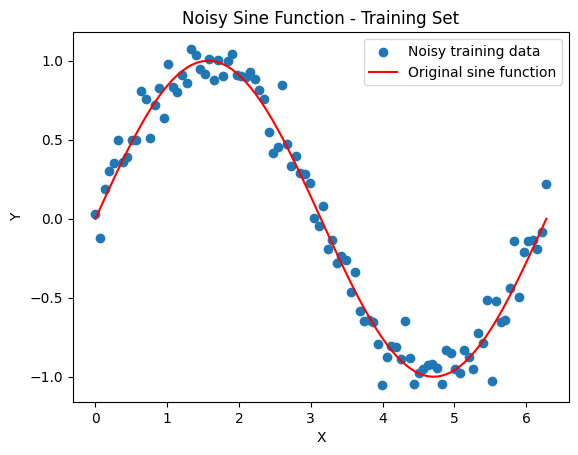

In [57]:
plt.scatter(X_train_data, Y_train_data, label='Noisy training data')
plt.plot(X_train_data, np.sin(X_train_data), label='Original sine function', color='red')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Noisy Sine Function - Training Set')
plt.show()

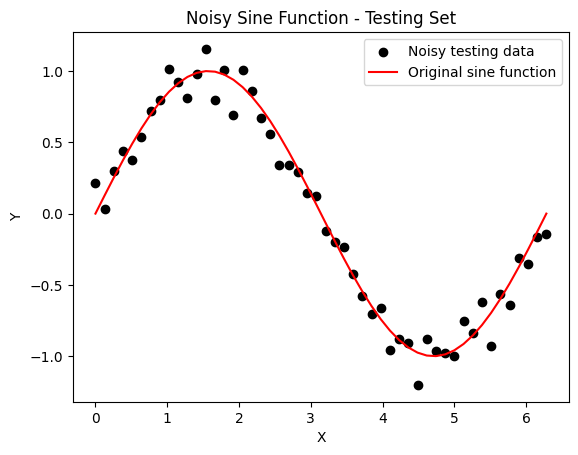

In [119]:
plt.scatter(X_test_data, Y_test_data, label='Noisy testing data', color='black')
plt.plot(X_test_data, np.sin(X_test_data), label='Original sine function', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Noisy Sine Function - Testing Set')
plt.show()

In [59]:
dev = qml.device('default.qubit', wires=4)

In [61]:
@qml.qnode(dev)
def circuit(weights, data):
    qml.AngleEmbedding(data, wires=range(4), rotation='X')
    qml.StronglyEntanglingLayers(weights=weights, wires=range(4))
    return qml.expval(qml.PauliZ(wires=0))

In [65]:
def sine_model(data, weights, bias):
    data_padded = jnp.pad(data, (0, max(0, 4 - data.shape[0])), mode='constant')
    return circuit(weights, data_padded) + bias

In [67]:
@jax.jit
def loss_func(params, data, targets):
    data = jnp.expand_dims(data, axis=1)  # Ensure data has correct shape
    preds = jax.vmap(lambda x: sine_model(x, params['weights'], params['bias']))(data)
    return jnp.mean((preds - targets) ** 2)

In [69]:
def accuracy(labels, predictions):
    return jnp.mean(jnp.abs(labels - predictions) < 1e-5)

In [71]:
layers = 3
w = jnp.ones([layers, 4, 3])  # Corrected shape to [layers, num_wires, 3]
b = jnp.array(0.15)
params = {'weights': w, 'bias': b}

In [73]:
opt = optax.adam(learning_rate=0.25)

@jax.jit
def update(params, opt_state, data, targets):
    loss_val, grads = jax.value_and_grad(loss_func)(params, data, targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val

In [75]:
def train(params, data, targets, num_epochs=60):
    opt_state = opt.init(params)
    for epoch in range(num_epochs):
        params, opt_state, loss_val = update(params, opt_state, data, targets)
        if epoch % 5 == 0:
            print(f"Epoch {epoch} - Loss: {loss_val:.6f}")
    return params

In [77]:
params = train(params, X_train_data, Y_train_data)

Epoch 0 - Loss: 0.468813
Epoch 5 - Loss: 0.038375
Epoch 10 - Loss: 0.030094
Epoch 15 - Loss: 0.017520
Epoch 20 - Loss: 0.016190
Epoch 25 - Loss: 0.013536
Epoch 30 - Loss: 0.012542
Epoch 35 - Loss: 0.012596
Epoch 40 - Loss: 0.012534
Epoch 45 - Loss: 0.012521
Epoch 50 - Loss: 0.012439
Epoch 55 - Loss: 0.012450


In [78]:
test_preds = jax.vmap(lambda x: sine_model(x, params['weights'], params['bias']))(jnp.expand_dims(X_test_data, axis=1))

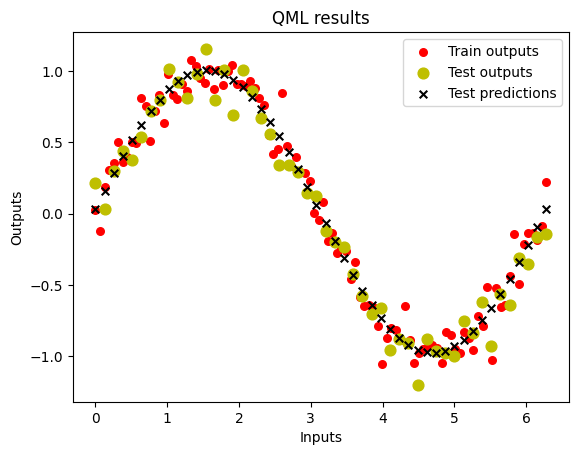

In [115]:
plt.scatter(X_train_data, Y_train_data, s=30, c='r', marker="o", label='Train outputs')
plt.scatter(X_test_data, Y_test_data, s=60, c='y', marker="o", label='Test outputs')
plt.scatter(X_test_data, test_preds, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")
plt.legend(loc='upper right')
plt.show()